In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
for dirname, _, filenames in os.walk('../input/NASA-bearing-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/NASA-bearing-dataset/merged_dataset_BearingTest_2.csv
../input/NASA-bearing-dataset/sample_1st.csv
../input/NASA-bearing-dataset/merged_dataset_BearingTest_1.csv
../input/NASA-bearing-dataset/sample_2nd.csv
../input/NASA-bearing-dataset/merged_dataset_BearingTest_3.csv
../input/NASA-bearing-dataset/sample_3rd.csv


In [6]:
#!pip install pyod
from pyod.models.auto_encoder import AutoEncoder

# Dataset preprocessing

In [7]:
# Read the CSV file and set first column as the dataframe index
dataset = pd.read_csv("../input/NASA-bearing-dataset/merged_dataset_BearingTest_2.csv", index_col=0)
dataset.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


## Normalize data

In [8]:
from sklearn import preprocessing

# Decide on what normalizer function to use
## https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml
scaler = preprocessing.MinMaxScaler() # scales all the data features in the range [0, 1] or if there are negative values to [-1, 1] 
#scaler = preprocessing.StandardScaler() # It follows Standard Normal Distribution (SND). Therefore, it makes mean = 0 and scales the data to unit variance

# If you needed to operate in the whole dataset, you could apply normalization to the full time series
#X_all = scaler.fit_transform(dataset)
#X_all = pd.DataFrame(dataset)
#X_all.columns = dataset.columns

# Dataset is scaled so that maximum for every column is 1
dataset_scaled = pd.DataFrame(scaler.fit_transform(dataset), 
                              columns=dataset.columns, 
                              index=dataset.index)
dataset_scaled.describe()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
count,984.000000,984.000000,984.000000,984.000000
mean,0.176344,0.485273,0.535517,0.393047
std,0.088842,0.073507,0.077007,0.081305
min,0.000000,0.000000,0.000000,0.000000
25%,0.131803,0.458450,0.505473,0.360049
50%,0.134550,0.464499,0.514541,0.364941
75%,0.181470,0.478561,0.530498,0.395511
max,1.000000,1.000000,1.000000,1.000000


## Split into training and test datasets
- We want the training set contains only "normal" data
- The rest of points will be in the test set, that will contain both "normal" and anomalous data

In [9]:
print("dataset_scaled shape is",dataset_scaled.shape,"\n\n", dataset_scaled.index)

dataset_scaled shape is (984, 4) 

 Index(['2004-02-12 10:32:39', '2004-02-12 10:42:39', '2004-02-12 10:52:39',
       '2004-02-12 11:02:39', '2004-02-12 11:12:39', '2004-02-12 11:22:39',
       '2004-02-12 11:32:39', '2004-02-12 11:42:39', '2004-02-12 11:52:39',
       '2004-02-12 12:02:39',
       ...
       '2004-02-19 04:52:39', '2004-02-19 05:02:39', '2004-02-19 05:12:39',
       '2004-02-19 05:22:39', '2004-02-19 05:32:39', '2004-02-19 05:42:39',
       '2004-02-19 05:52:39', '2004-02-19 06:02:39', '2004-02-19 06:12:39',
       '2004-02-19 06:22:39'],
      dtype='object', length=984)


We will split into training and test sets:
 
 - The **training set** corresponds to the first part of the time serie (25% approximately), where bearing status is healthy
     - It will train the **Autoencoder model**
     - So the training step will provide with the **baseline** that we will use to flag anomalies later
     
 - The **test set** covers the remaining 75% of the of the serie (right part)
     - We will apply on it the threshold value provided by the autoencoder model (baseline)
     - Then we will flag as anomalous every point whose score is above the threshold

In [10]:
dataset_train = dataset_scaled[:'2004-02-13 23:52:39']
dataset_test  = dataset_scaled['2004-02-14 00:02:39':]
# Random shuffle training data
dataset_train.sample(frac=1)

print("Train dataset has lenght", dataset_train.shape[0], "while test dataset is", dataset_test.shape[0],
      "TOTAL=", dataset_train.shape[0]+dataset_test.shape[0])

Train dataset has lenght 225 while test dataset is 759 TOTAL= 984


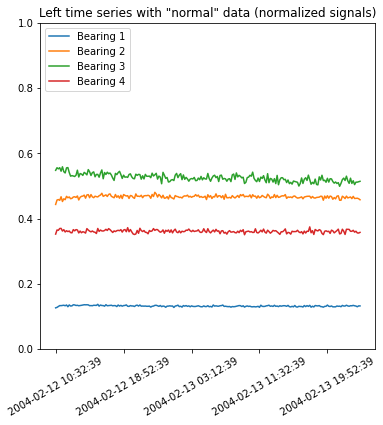

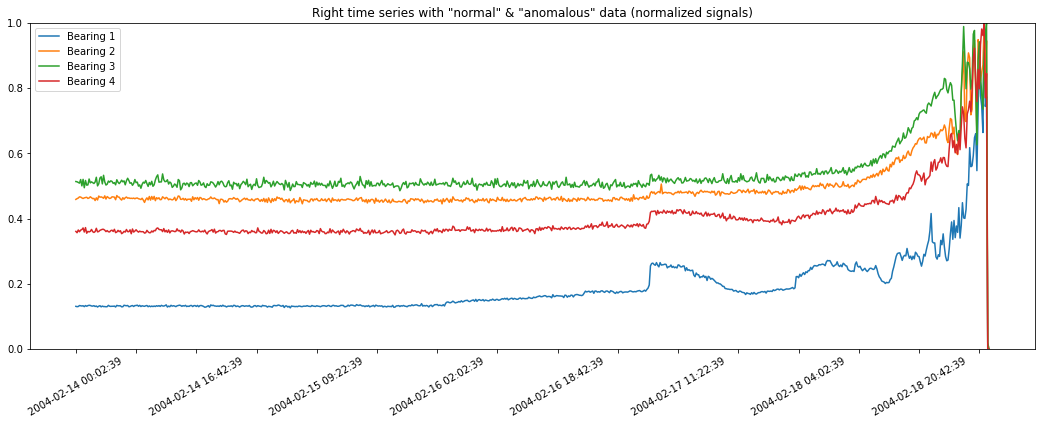

In [11]:
x_ticks_span = 50

dataset_train.plot(figsize = (6,6), title ='Left time series with "normal" data (normalized signals)')
plt.xticks(np.arange(0, dataset_train.shape[0], x_ticks_span), fontsize=10, rotation = 30)
plt.ylim(0,1)
plt.legend(loc="upper left")  
plt.show()

dataset_test.plot(figsize = (18,6), title='Right time series with "normal" & "anomalous" data (normalized signals)')
plt.xticks(np.arange(0, dataset_test.shape[0], x_ticks_span), fontsize=10, rotation = 30)
plt.ylim(0,1)
plt.legend(loc="upper left")  
plt.show()

## Scatter plot with two components (PCA) for visualization purposes
Training of the model will use the 4 bearings data, not the PCA.
In fact, the Autoencoder model will have a central (hidden) layer with two nodes that is similar to PCA concept, with the improvement that is able to deal with non linear models. 

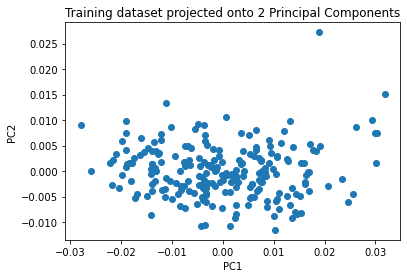

In [12]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(dataset_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
plt.scatter(x_pca['PC1'], x_pca['PC2'])
plt.title('Training dataset projected onto 2 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Build autoencoder model
https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.auto_encoder

We don't need to apply dimensional reduction, it's done by the Autoencoder model (central layer of two nodes in the Neural Network are the equivalent to the 2 Principal Components)

In [13]:
clf1 = AutoEncoder(hidden_neurons =[10, 2, 10], contamination=0.05, epochs=150, batch_size=30)
clf1.fit(dataset_train)

# These are the default parameters used:
'''
AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[10, 2, 10],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7ffacc1150e0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)
'''

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50        
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2

7/7 [==============================] - 0s 7ms/step - loss: 1.0584 - val_loss: 1.6707
Epoch 67/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0821 - val_loss: 1.6679
Epoch 68/150
7/7 [==============================] - 0s 7ms/step - loss: 1.1010 - val_loss: 1.6653
Epoch 69/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0485 - val_loss: 1.6624
Epoch 70/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0994 - val_loss: 1.6597
Epoch 71/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0374 - val_loss: 1.6572
Epoch 72/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0359 - val_loss: 1.6547
Epoch 73/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0710 - val_loss: 1.6521
Epoch 74/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0630 - val_loss: 1.6495
Epoch 75/150
7/7 [==============================] - 0s 7ms/step - loss: 1.0772 - val_loss: 1.6472
Epoch 76/150
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.9870 - val_loss: 1.5436
Epoch 150/150
7/7 [==============================] - 0s 7ms/step - loss: 0.9956 - val_loss: 1.5421


"\nAutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,\n      hidden_activation='relu', hidden_neurons=[10, 2, 10],\n      l2_regularizer=0.1,\n      loss=<function mean_squared_error at 0x7ffacc1150e0>,\n      optimizer='adam', output_activation='sigmoid', preprocessing=True,\n      random_state=None, validation_size=0.1, verbose=1)\n"

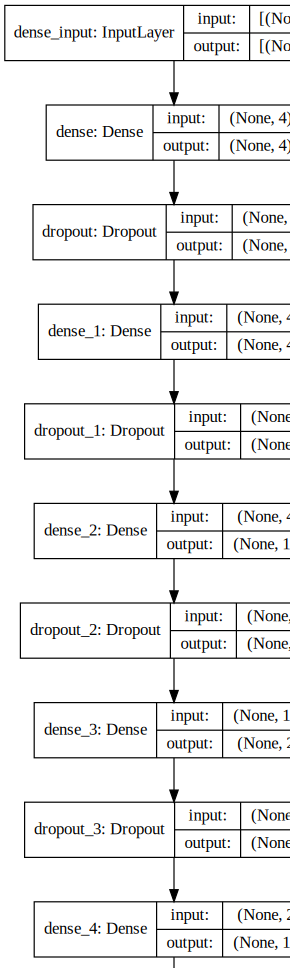

In [14]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(clf1.model_, dpi=60, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

## Evaluate the model: validation vs. training loss

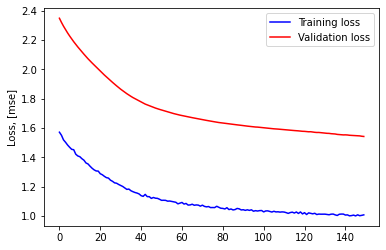

In [15]:
plt.plot(clf1.history_['loss'],     'b', label='Training loss')
plt.plot(clf1.history_['val_loss'], 'r', label='Validation loss')
plt.legend(loc='upper right')
# plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

# Inferring the anomaly decision logic  from the Autoencoder model
PyOD autoencoder model provides us directly with:
- Prediction scores
- Anomaly threshold
- Anomaly points labels ("1" if score > threshold, "0" otherwise)

This applies for the baseline signal (training set).

In [16]:
# Get the outliers' scores for the training data
y_training_scores = clf1.decision_scores_ # = clf1.decision_function(dataset_train)
# Threshold value is based on default parameter `contamination=0.1`
threshold = clf1.threshold_
# Outliers are labeled with "1", the rest with "0"
y_training_pred = clf1.labels_

In [17]:
print("Points whose score is greater than", "{:.2f}".format(threshold), "would be labeled as anomalies")

Points whose score is greater than 3.10 would be labeled as anomalies


Look af the scores's histogram to visually check for the threshold.

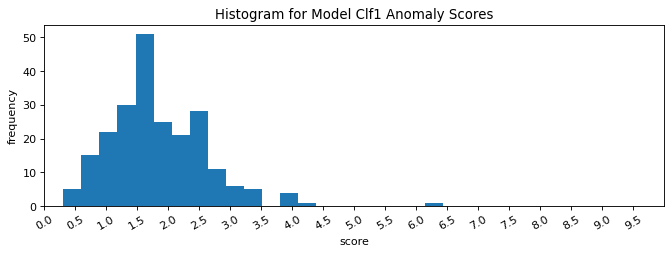

In [18]:
figure(figsize=(10, 3), dpi=80)
plt.hist(y_training_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.xticks(np.arange(0, 10, 0.5), fontsize=10, rotation = 30)
plt.xlim(0,10)
plt.ylabel("frequency")
plt.xlabel("score")
plt.show()

In the following section we will inspect the results to decide on the threshold value we will apply to the test set:
- In doing this, one can make sure that this threshold is set above the “noise level” of the baseline signal, and that any flagged anomalies should be statistically significant above the noise background (**see the figure below**).
- Then by applying the logic `score > threshold` for the reamining 75% of time series (test set) we will be able to flag outliers, because we have implicitly subtracted the noise background present in the *healthy* signal (training set) with that selected threshold.

**NOTE:** In the baseline signal (training set) the unequality`score > threshold` has detected outliers as background noise), i.e. because higher scores corresponds to low frequency occurrences.

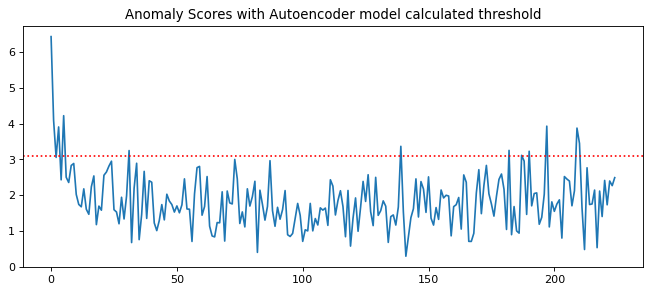

In [19]:
figure(figsize=(10, 4), dpi=80)
plt.plot(y_training_scores)
plt.axhline(y=threshold, c='r', ls='dotted', label='threshoold')

plt.title('Anomaly Scores with Autoencoder model calculated threshold')
plt.show()

An outlier is a point that is distant from others, so the **score** value can be understood *as a distance*. Let's add a column in the training set to flag the anomalies.

## Decision on the threshold value
Here you need to decide on the precise cut point for your actual problem by taking into account its context:
* **Increase** the threshold if you want to be *more risky* (be as close as possible to the bearing break point).
   - This way you delay the bearig replacement based on your prediction
* Keep as it is, or slightly **decrease** the threshold value.
   - This way you will be more conservative and can anticipate the replacement for safety operations' reasons, avoiding  unexpected breakage (it might happen before what the model predicts)
   
We decide to **set to 3.66** so that results are comparable to the calculation based on the [PCA method](https://www.kaggle.com/brjapon/nasabearingdataset-pca-outliers-detection)

In [20]:
threshold = 3.66 # Increased to avoid false positive at the initial part of the test set

## Get the scores of both datasets

In [21]:
y_training_scores = clf1.decision_function(dataset_train)
y_testing_scores  = clf1.decision_function(dataset_test)

## Add anomaly flags to dataset_train & dataset_test

In [22]:
# Do it on not normalized dataframes, so that there are no step between training and test (remember that they were scaled independently)
#  - With    _ is the original dataset (non scaled)
#  - Without _ is the scaled dataset (range 0-1)
dataset_train['score']     = y_training_scores
dataset_train['threshold'] = threshold
# We have to re-calculate anomaly flags (y_training_pred) since we changed the threshold
dataset_train_anomalies = dataset_train['score'] > threshold

dataset_train['anomaly'] = dataset_train_anomalies
dataset_train.tail()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,score,threshold,anomaly
2004-02-13 23:12:39,0.132726,0.461699,0.504309,0.358591,2.416001,3.66,False
2004-02-13 23:22:39,0.131954,0.462257,0.511815,0.361244,1.735942,3.66,False
2004-02-13 23:32:39,0.129729,0.462541,0.511791,0.356115,2.400454,3.66,False
2004-02-13 23:42:39,0.132462,0.460973,0.512991,0.355770,2.270451,3.66,False
2004-02-13 23:52:39,0.132325,0.457791,0.514378,0.357767,2.493561,3.66,False


In [23]:
dataset_test['score'] = y_testing_scores
dataset_test['threshold'] = threshold
dataset_test_anomalies = dataset_test['score'] > threshold
dataset_test['anomaly'] = dataset_test_anomalies
dataset_test.tail()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,score,threshold,anomaly
2004-02-19 05:42:39,1.000000,1.000000,0.907962,1.000000,495.210393,3.66,True
2004-02-19 05:52:39,0.744004,0.821423,0.958115,0.770575,346.758345,3.66,True
2004-02-19 06:02:39,0.773924,0.945396,1.000000,0.844652,372.673870,3.66,True
2004-02-19 06:12:39,0.001523,0.018499,0.019523,0.000745,148.117214,3.66,True
2004-02-19 06:22:39,0.000000,0.000000,0.000000,0.000000,151.563707,3.66,True


Retain in `X_train_anomalies` and `X_test_anomalies` only the anomalies for plotting below

In [24]:
print("There are", dataset_train[ dataset_train['score'] > threshold ].shape[0], "anomalies in the training set out of", dataset_train.shape[0], "points")
print("There are",  dataset_test[ dataset_test['score'] > threshold ].shape[0], "anomalies in the training set out of", dataset_test.shape[0], "points")

There are 6 anomalies in the training set out of 225 points
There are 519 anomalies in the training set out of 759 points


# Predict the degradation point

In [25]:
anomaly_train = dataset_train[['score', 'threshold', 'anomaly']]

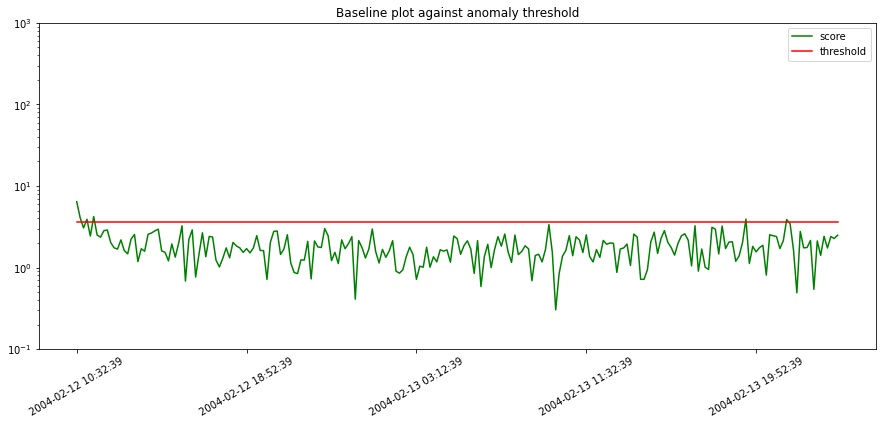

In [26]:
anomaly_train.plot(logy=True, figsize = (15,6), ylim = [1e-1,1e3], color = ['green','red'])
plt.xticks(np.arange(0, anomaly_train.shape[0], 50), fontsize=10, rotation = 30)
plt.title('Baseline plot against anomaly threshold')
plt.show()

In [27]:
anomaly = dataset_test[['score', 'threshold', 'anomaly']]
anomaly_alldata = pd.concat([anomaly_train, anomaly])

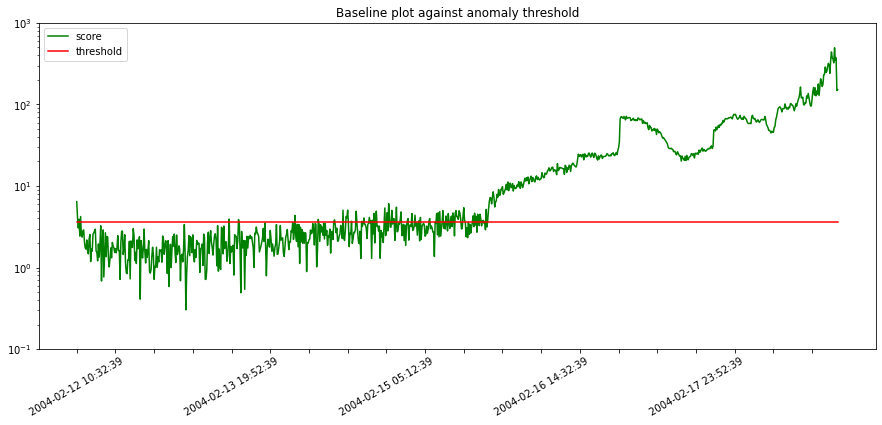

In [28]:
anomaly_alldata.plot(logy=True, figsize = (15,6), ylim = [1e-1,1e3], color = ['green','red'])
plt.xticks(np.arange(0, anomaly_alldata.shape[0], 50), fontsize=10, rotation = 30)
plt.title('Baseline plot against anomaly threshold')
plt.show()

# Conclusions
- For the same threshold than the PCA analysis (= 3.66), the degradation point occurs one day before (15-feb 22:00)

## Weak points
- The neural network does not seem to converge
- The validation loss is always greater than the training loss: this has no sense